# Intro - Predicting House Sale Prices 

 - Exploring ways to improve the models we've built
 




## The Data

We'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. 

This dataset was originally compiled by [Dean De Cock](http://www.truman.edu/faculty-staff/decock/) for the primary purpose of having a high quality dataset for regression. You can read more about his process and motivation [here](https://doi.org/10.1080/10691898.2011.11889627) and download the dataset [here](https://dsserver-prod-resources-1.s3.amazonaws.com/235/AmesHousing.txt). There is also a data dictionary [here](http://www.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

Here are some of the columns:

 - `Lot Area`: Lot size in square feet.
 
 - `Overall Qual`: Rates the overall material and finish of the house.
 
 - `Overall Cond`: Rates the overall condition of the house.
 
 - `Year Built`: Original construction date.
 
 - `Low Qual Fin SF`: Low quality finished square feet (all floors).
 
 - `Full Bath`: Full bathrooms above grade.
 
 - `Fireplaces`: Number of fireplaces.
 
 Let's start by setting up a pipeline of functions that will let us quickly iterate on different models.
 
 `Train -> transform_features -> select_features -> train_and_test -> rmse_values, avg_mse`

In [30]:
# Import needed modules

import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

In [31]:
# Read the data in 

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")

In [32]:
# Set up our functions

def transform_features(df):
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    
    ## You can use `pd.DataFrame.select_dtypes()` to specify column types
    ## and return only those columns as a data frame.
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    ## You can use `pd.Series.drop()` to drop a value.
    features = numeric_train.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.25161263909

## Feature Engineering

Let's now start removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns. 

We also need to remove any columns that leak information about the sale (e.g. like the year the sale happened). 
 
Steps:

Handle missing values:
 - All columns:
 
   - Drop any with 5% or more missing values for now.
 
 - Text columns:

   - Drop any with 1 or more missing values for now.

 - Numerical columns:
 
   - For columns with missing values, fill in with the most common value in that column


All columns, drop any which have >5% null values:

In [33]:
# Series object: column name -> number of missing values
num_missing = df.isnull().sum()

In [34]:
# Filter Series to columns containing >5% missing values
drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()

# Drop those columns from the data frame. Use .index accessor
df = df.drop(drop_missing_cols.index, axis=1)

Now for text columns, drop any with >1 null value:

In [35]:
# Series object: column name -> number of missing values
text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)

# Filter Series to columns containing *any* missing values
drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]

df = df.drop(drop_missing_cols_2.index, axis=1)

Next the numerical columns, fill in the empty columns with most common value:

In [36]:
# Compute column-wise missing value counts
num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
fixable_numeric_cols

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [37]:
# Compute the most common value for each column in `fixable_nmeric_missing_cols`.
replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Mas Vnr Area': 0.0}

In [38]:
# Use `pd.DataFrame.fillna()` to replace missing values.
df = df.fillna(replacement_values_dict)

In [39]:
# Verify that every column has 0 missing values
df.isnull().sum().value_counts()

0    64
dtype: int64

Determining what transformations are necessary:

In the Data Dictionary we find the following note:
 
#### Potential Pitfalls (Outliers): 

_Although all known errors were corrected in the data, no observations have been removed due to unusual values and all final residential sales from the initial data set are included in the data presented with this article._ 

_There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points)._

_Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately)._ 

_I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations)_

What new features can we create, that better capture the information?

In [40]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [41]:
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [42]:
# Create new columns
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

# Drop rows with negative values for both of these new features
df = df.drop([1702, 2180, 2181], axis=0)

# No longer need original year columns
df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)

We'll now drop columns that:

 - that aren't useful for ML (`PID`, `Order`)
 
 - leak data about the final sale (`Mo Sold`, `Sale Condition`, `Sale Type`, `Yr Sold`)

In [43]:
# Drop columns that aren't useful for ML
df = df.drop(["PID", "Order"], axis=1)

# Drop columns that leak info about the final sale
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

We'll update `transform_features()` so that any column from the data frame with more than 25% (or another cutoff value) missing values is dropped. 

In general, the goal of this function is to:

- remove features that we don't want to use in the model, just based on the number of missing values or data leakage
 - transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
 - create new features by combining other features

In [44]:
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.36731241307

## Feature Selection

Now that we have cleaned and transformed a lot of the features in the data set, it's time to move on to feature selection for numerical features.

Steps:

Generate a correlation heatmap matrix of the numerical features in the training data set.

 - Which features correlate strongly with our target column, `SalePrice`?
 
 - Calculate the correlation coefficients for the columns that seem to correlate well with `SalePrice`. Because we have a pipeline in place, it's easy to try different features and see which features result in a better cross validation score.
 
 - Which columns in the data frame should be converted to the categorical data type? 
   - All of the columns that can be categorized as nominal variables are candidates for being converted to categorical. 
   - Here are some other things you should think about:
     - If a categorical column has hundreds of unique values (or categories), should you keep it? When you dummy code this column, hundreds of columns will need to be added back to the data frame.

     - Which categorical columns have a few unique values but more than 95% of the values in the column belong to a specific category? This would be similar to a low variance numerical feature (no variability in the data for the model to capture).
     
     - Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?
     
     - What are some ways we can explore which categorical columns "correlate" well with `SalePrice`?

[This post](http://machinelearningmastery.com/feature-selection-machine-learning-python/) by Jason Brownlee on Machine Learning Mastery indicates some potential strategies:

 - Univariate Selection
 
 - Recursive Feature Elimination
 
 - Principal Component Analysis

Update the logic for the `select_features()` function. This function should take in the new, modified train and test data frames that were returned from `transform_features()`.

In [45]:
numerical_df = transform_df.select_dtypes(include=['int', 'float'])
numerical_df.head(5)

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Yr Sold,SalePrice,Years Before Sale,Years Since Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,2010,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,2010,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,2010,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,2010,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,2010,189900,13,12


In [46]:
abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
abs_corr_coeffs

BsmtFin SF 2         0.006127
Misc Val             0.019273
Yr Sold              0.030358
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice 

In [47]:
# Let's only keep columns with a correlation coefficient of larger than 0.4 (arbitrary, worth experimenting later!)
abs_corr_coeffs[abs_corr_coeffs > 0.4]

BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: SalePrice, dtype: float64

In [48]:
# Drop columns with less than 0.4 correlation with SalePrice
transform_df = transform_df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.4].index, axis=1)

In [49]:
# Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [50]:
# Which categorical columns have we still carried with us? We'll test these 
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

# How many unique values in each categorical column?
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()

# Arbitrary cutoff of 10 unique values (worth experimenting)
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
transform_df = transform_df.drop(drop_nonuniq_cols, axis=1)

In [51]:
# Select just the remaining text columns and convert to categorical
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
# Create dummy columns and add back to the dataframe!
transform_df = pd.concat([
    transform_df, 
    pd.get_dummies(transform_df.select_dtypes(include=['category']))
], axis=1).drop(text_cols,axis=1)

Update `select_features()`

In [53]:
def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

33367.28718340316

## Train and Test

Now for the final part of the pipeline, training and testing. When iterating on different features, using simple validation is a good idea. Let's add a parameter named k that controls the type of cross validation that occurs.

In [54]:
def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse

[26894.85111391291, 36832.57427201166, 27309.57504317141, 25241.781689005264]


29069.695529525314

## Next Steps


 - Continue iteration on feature engineering:

   - Research some other approaches to feature engineering online around housing data.

   - Visit the Kaggle [kernels](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels) page for this dataset to see approaches others took.
   
 - Improve feature selection:
 
   - Research ways of doing better feature selection with categorical columns (something we didn't cover in this particular course).

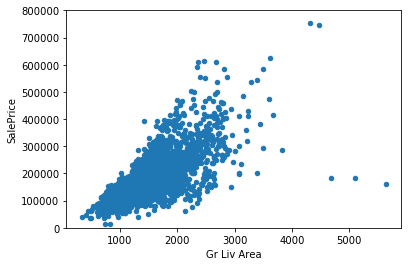

In [57]:
#scatter plot gr liv area/saleprice
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
var = 'Gr Liv Area'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

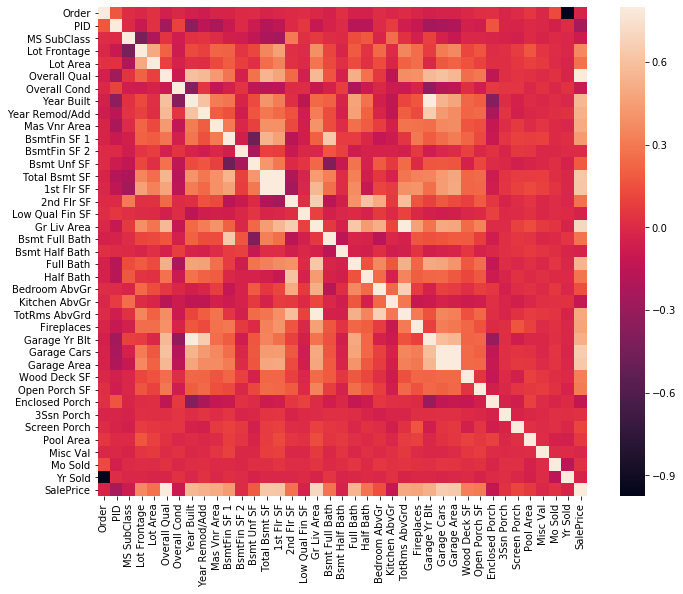

In [59]:
import seaborn as sns
# correlation heatmap
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

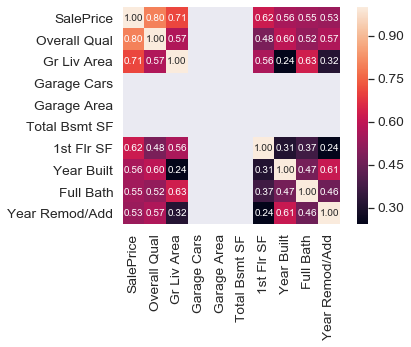

In [61]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

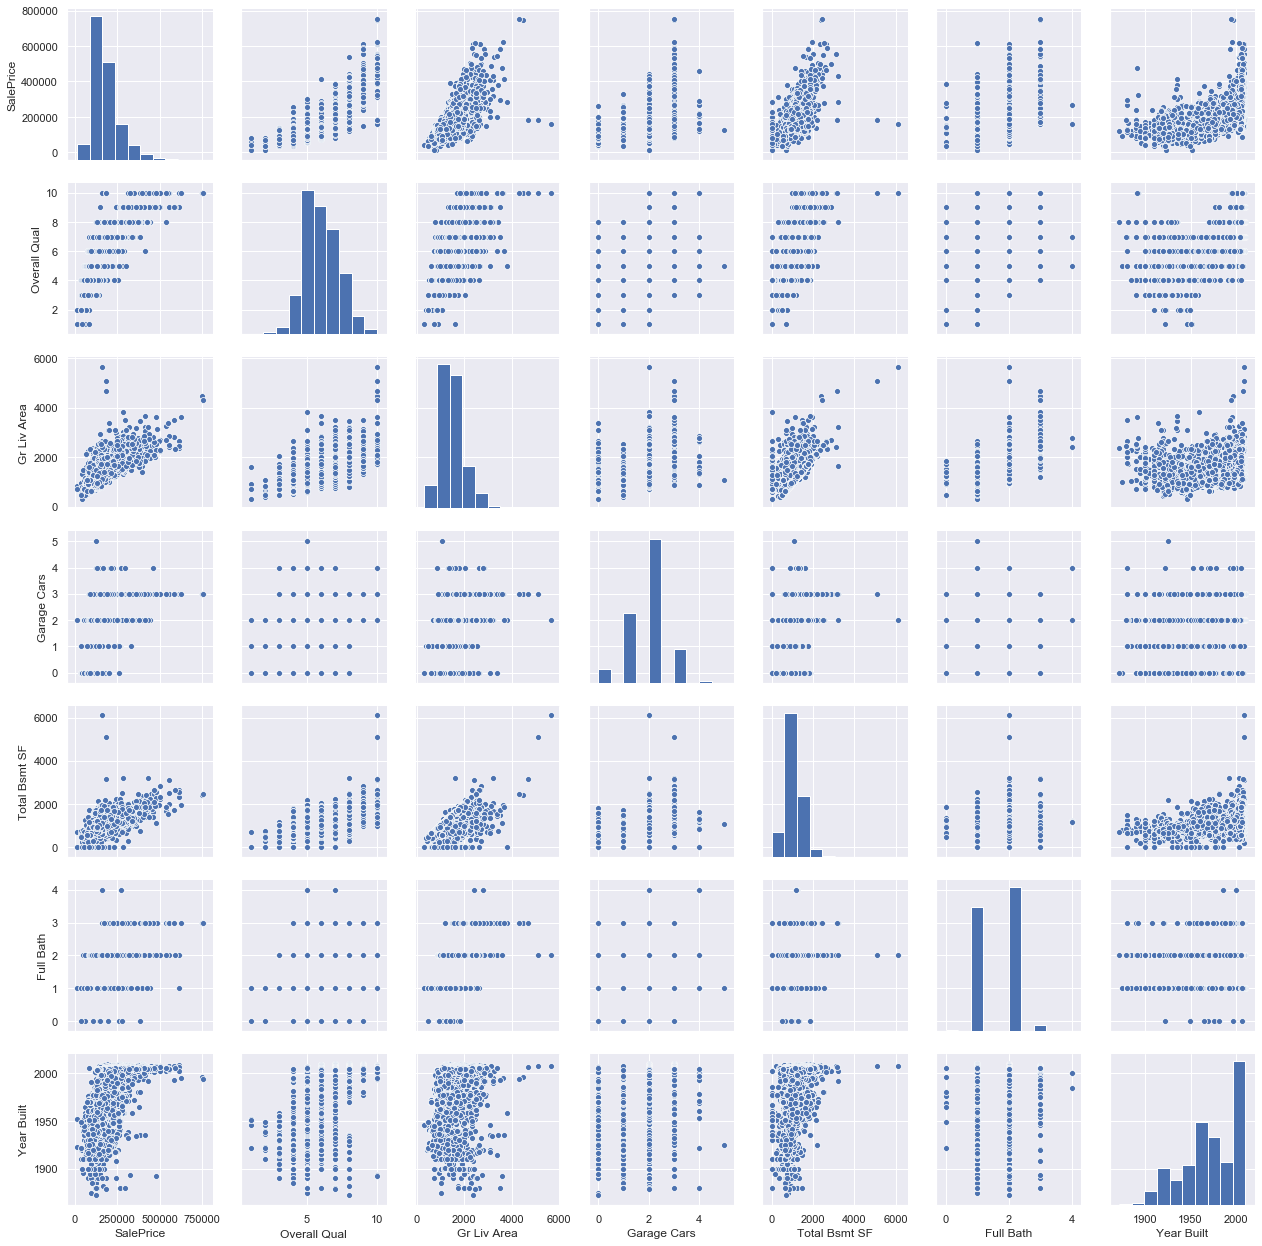

In [64]:
#scatterplot
sns.set()
cols = ['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', 'Full Bath', 'Year Built']
sns.pairplot(df[cols], height = 2.5)
plt.show();

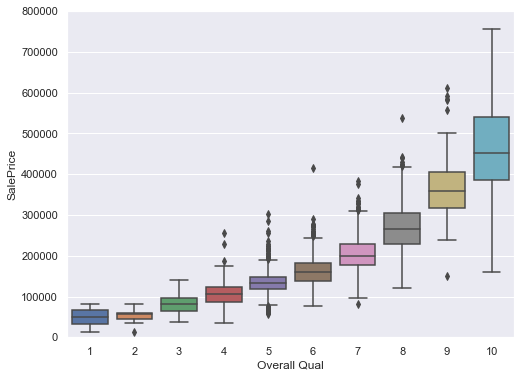

In [68]:
#box plot overallqual/saleprice
var = 'Overall Qual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);